In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import tqdm
from data import load_data
import matplotlib.pyplot as plt
from model import Generator, Critic
import torchvision


In [ ]:
def evaluate(generator: Generator, critic: Critic, test_loader, num_data, batch_size, device, latent_dim):
    generator.eval()
    critic.eval()
    progress_bar = tqdm.tqdm(test_loader)
    generator_losses = []
    critic_losses = []
    for i, (images, _) in enumerate(progress_bar):
      with torch.no_grad():
            real_img_batch = images.to(device)
            latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
            x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
            fake_img_batch = generator(x)
            
            # Descriminate
            D_real = critic(real_img_batch).squeeze() # (5, 1)
            D_fake = critic(fake_img_batch).squeeze() # Descrimating Generated image
            
            D_loss = - (D_real.mean() - D_fake.mean())
            G_loss = - (D_fake.mean())         
              
            generator_losses.append(G_loss.item())
            critic_losses.append(D_loss.item())
          
      if i == num_data:
          break
    
    eval_generator_mean_loss = torch.tensor(generator_losses).mean()
    eval_critic_mean_loss = torch.tensor(critic_losses).mean()
    
    # Show a grid of generated images
    latent_inp = torch.randn(size=(16, latent_dim)).to(device) # (b, h)
    x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
    fake_samples = generator(x).detach().cpu()
    grid = torchvision.utils.make_grid(fake_samples, nrow=4, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    
    generator.train()
    critic.train()
    
    return eval_critic_mean_loss, eval_generator_mean_loss
 
def train(generator, critic, num_epochs, eval_epoch, device, batch_size, sample_size, n_critic, latent_dim):
    generator.to(device)
    critic.to(device)
    D_optimizer = torch.optim.AdamW(critic.parameters(), lr=1e-5, weight_decay=0.001, betas=(0.5, 0.999))
    G_optimizer = torch.optim.AdamW(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
    train_loader, test_loader = load_data(train_batch_size=batch_size, test_batch_size=2, sample_size=sample_size)
    
    
    for epoch in range(num_epochs):
        progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
        generator.train()
        critic.train()
        progress.set_description(f'Epoch: {epoch}')
        generator_losses = []
        critic_losses = []
        
        for images, _ in progress:
            real_images = images.to(device)
            
            for _ in range(n_critic):
                
                latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
                x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
                fake_images = generator(x)
            
                # Descriminate
                D_real = critic(real_images).squeeze() # (5, 1)
                D_fake = critic(fake_images).squeeze() # Descrimating Generated image
                
                D_loss = - (D_real.mean() - D_fake.mean())

                D_optimizer.zero_grad()
                D_loss.backward()
                D_optimizer.step()
                
                for p in critic.parameters():
                    p.data.clamp_(-0.01, 0.01)

            
            
            G_optimizer.zero_grad()
            latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
            x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
            fake_images = generator(x)
            D_fake = critic(fake_images).squeeze() # Descrimating Generated image
            G_loss = - torch.mean(D_fake)
            G_loss.backward()
            G_optimizer.step()
            
            generator_losses.append(G_loss.item())
            critic_losses.append(D_loss.item())
            
            progress.set_postfix({'generator_loss': f"{G_loss.item():.4f}", 'critic_loss': f"{D_loss.item():.4f}"})
            
      
        # generator_mean_loss = torch.tensor(generator_losses).mean()
        # critic_mean_loss = torch.tensor(critic_losses).mean()
       
        eval_critic_loss, eval_generator_loss = evaluate(generator, critic, test_loader, num_data=20, batch_size=2, device=device, latent_dim=latent_dim)
        
       
      
          
    

  0%|          | 20/5000 [00:00<00:25, 194.61it/s]


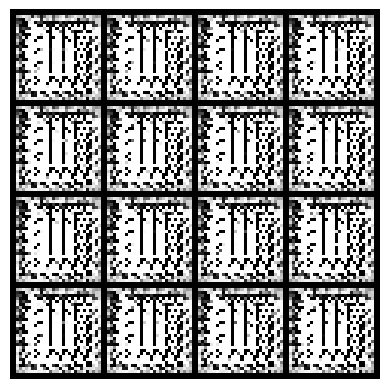

Epoch: 1:  16%|█▌        | 5/32 [00:05<00:30,  1.14s/it, generator_loss=-0.0104, critic_loss=0.0000]


KeyboardInterrupt: 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 512
generator = Generator(latent_dim=latent_dim, device=device)
critic = Critic()


train(generator=generator, critic=critic, num_epochs=100, eval_epoch=20, device=device, batch_size=32, sample_size=1000, n_critic=5, latent_dim=latent_dim)